# Test outlier detection methods on conductivity data

In [1]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

import os
import pandas as pd
import numpy as np
import pickle
import ternary
import pymatgen as mg
from helpers import fileload as fl
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks
from helpers.outlier_detect import z_score, flag_outliers
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ImportError: cannot import name 'flag_outliers'

In [23]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')
pickledir = os.path.join(tcodir,'scripts/pickles')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots/outliers')
src = 'in'

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

# Data load

In [24]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]

for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':'dry'})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['Sigma_elec']>=0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_sigma'] = np.log10(data['Sigma_elec'])


# Z-score

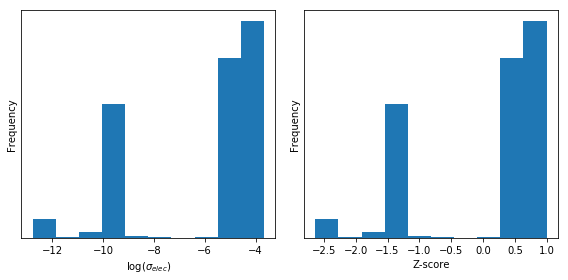

In [25]:
fig, axes = plt.subplots(1,2,figsize=(8,4),sharey=True)
axes[0].hist(data['log_sigma'])
axes[0].set_xlabel('log($\sigma_{elec}$)')
axes[1].hist(z_score(data['log_sigma']))
axes[1].set_xlabel('Z-score')

for ax in axes:
    ax.set_yticks([])
    ax.set_ylabel('Frequency')
    
fig.tight_layout()
#fig.savefig(os.path.join(plotdir,'log_sigma_hist.png'),dpi=350)

# Isolation forest

Scale: 0.95
Scale: 0.95
Scale: 0.85
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


Text(0.5,1.1,'Outliers')

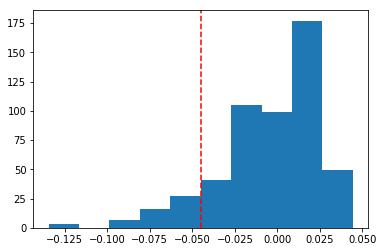

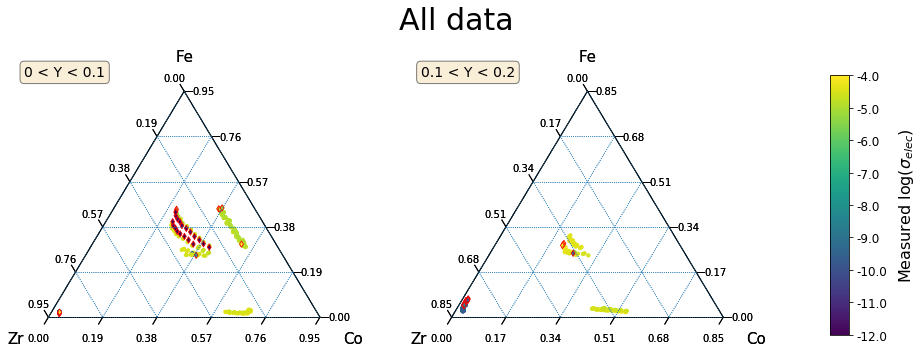

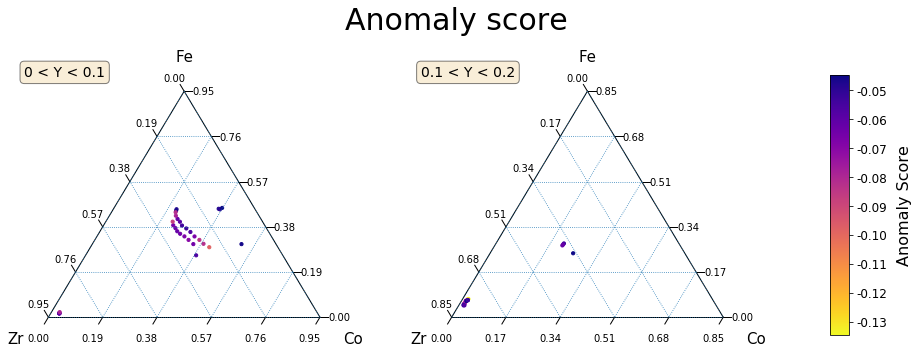

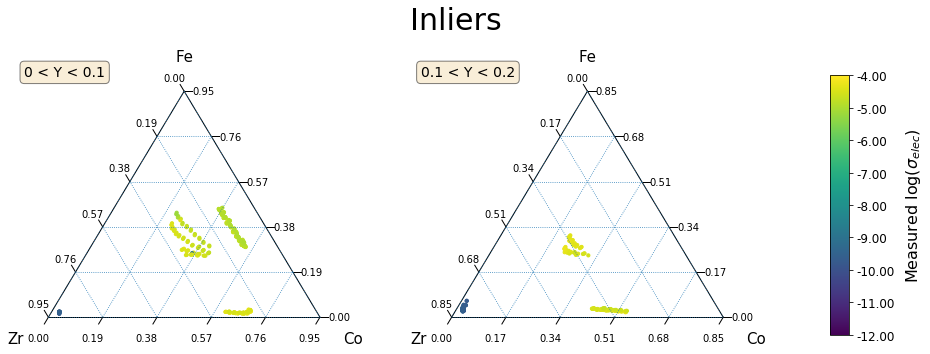

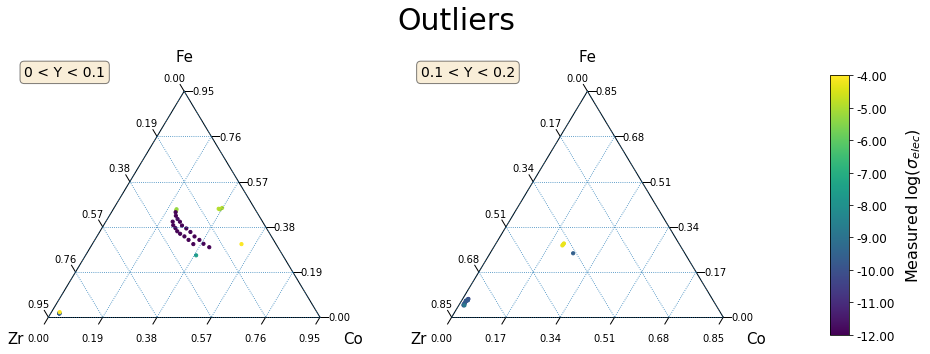

In [5]:
isolation_dimensions = ['Ba','Co','Fe','Zr','Y','log_sigma']
isolation_data = data.loc[:,isolation_dimensions]

thresh_adjust = 0

X_iso = isolation_data.values

rand_state = np.random.RandomState(23)

clf = IsolationForest(random_state=rand_state,max_features=6,bootstrap=True)
clf.fit(X_iso)

flags = clf.predict(X_iso)
scores = clf.decision_function(X_iso)

isolation_data['outlier_flag'] = flags
isolation_data['outlier_score'] = scores
#isolation_data['Y'] = data['Y'] #for plotting

outlier_thresh = isolation_data.loc[isolation_data['outlier_flag']==-1,'outlier_score'].max()
outlier_thresh += thresh_adjust

inliers = isolation_data.loc[isolation_data['outlier_score'] > outlier_thresh,:]
outliers = isolation_data.loc[isolation_data['outlier_score'] <= outlier_thresh,:]

#plot histogram of outlier score
fig, ax = plt.subplots()
ax.hist(isolation_data['outlier_score'])
ax.axvline(outliers['outlier_score'].max(),color='r',ls='--')
# ax.scatter(isolation_data['log_sigma'],isolation_data['outlier_score'],c=isolation_data['outlier_flag'])
# ax.set_xlabel('log($\sigma$)')
# ax.set_ylabel('Anomaly score')

#ternary plots of all data with outliers outlined in red
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=20,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},
                      scatter_kw=dict(marker='d',edgecolors='red',linewidths=0.8))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('All data',size=30,y=1.1)

#ternary plots of outliers only - plot anomaly scores
vmin = outliers['outlier_score'].min()
vmax = outliers['outlier_score'].max()
cmap = plt.cm.plasma_r
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(outliers,z='outlier_score',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Anomaly Score',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Anomaly score',size=30,y=1.1)

#ternary plots of inliers only - plot log_sigma
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Inliers',size=30,y=1.1)

#ternary plots of outliers only - plot log_sigma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Outliers',size=30,y=1.1)



(array([ 8., 10.,  8.,  4., 15., 26., 31.,  5.,  0.,  1.]),
 array([-10.03918119,  -9.95610193,  -9.87302267,  -9.7899434 ,
         -9.70686414,  -9.62378488,  -9.54070562,  -9.45762635,
         -9.37454709,  -9.29146783,  -9.20838856]),
 <a list of 10 Patch objects>)

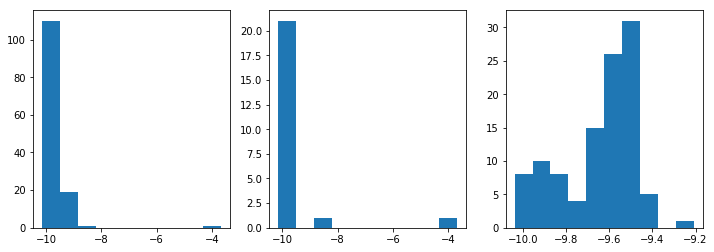

In [6]:
isolation_data['sample'] = data['sample']
df = isolation_data[isolation_data['sample']=='PDAC_COM3_01255']
df_out = df[df['outlier_score']<=outlier_thresh]
df_in = df[df['outlier_score']>outlier_thresh]

fig, axes = plt.subplots(1,3,figsize=(12,4))
axes[0].hist(df['log_sigma'])
axes[1].hist(df_out['log_sigma'])
axes[2].hist(df_in['log_sigma'])

# DBSCAN

In [10]:
db_data = data.copy()
comp_dims = ['Ba','Co','Fe','Zr','Y']
db_dims = comp_dims + ['log_sigma']

db_data_scaled = db_data.copy()

#scale largest-variance atomic fraction to unit variance
#scale other atomic fractions with same transform
ref_dim = np.var(db_data[comp_dims]).idxmax()
rs_comp = StandardScaler()#with_centering=False)
rs_comp.fit(db_data[ref_dim].values[:,None])
#scaler = get_scaler(db_data[ref_dim])
db_data_scaled[comp_dims] = rs_comp.transform(db_data[comp_dims]) #scaler(db_data[comp_dims])


#scale log_sigma using sklearn's RobustScaler - robust to outliers (no outliers in composition)
rs_z = RobustScaler(with_centering=False)
db_data_scaled['log_sigma'] = 2*rs_z.fit_transform(db_data['log_sigma'].values[:,np.newaxis])

db = DBSCAN(metric='manhattan',eps=0.25,min_samples=8)
db_data['cluster'] = db.fit_predict(db_data[db_dims])
db_data
outliers = db_data.loc[db_data['cluster']==-1,:]
inliers = db_data.loc[db_data['cluster']!=-1,:]

Scale: 0.95
Scale: 0.95
Scale: 0.85
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


Text(0.5,1.1,'Clusters')

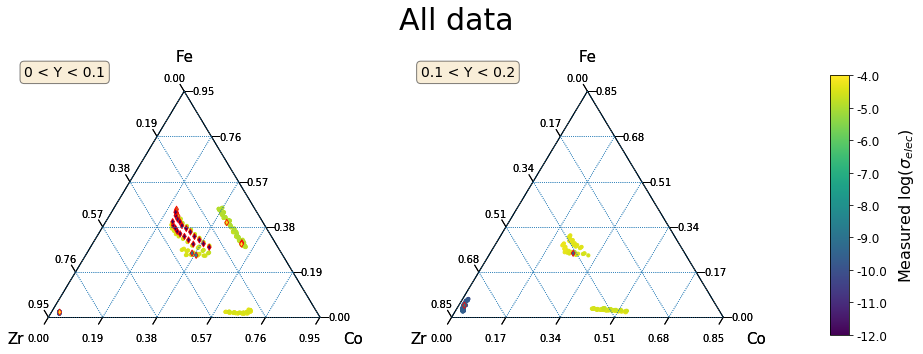

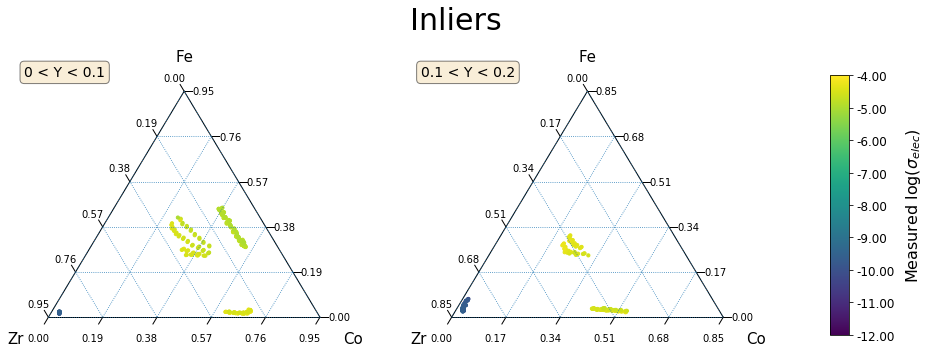

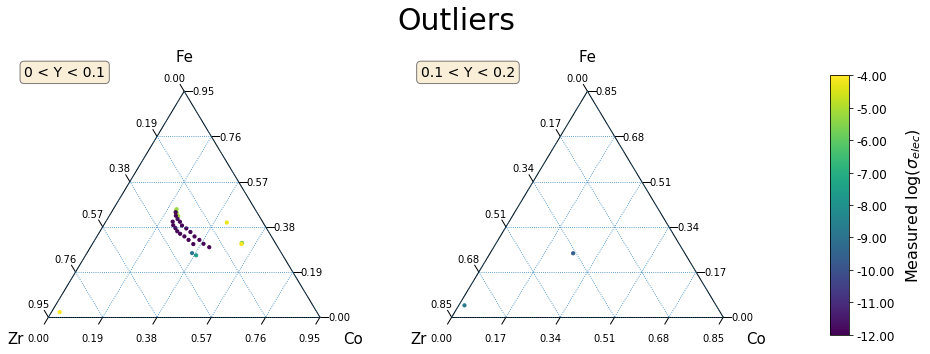

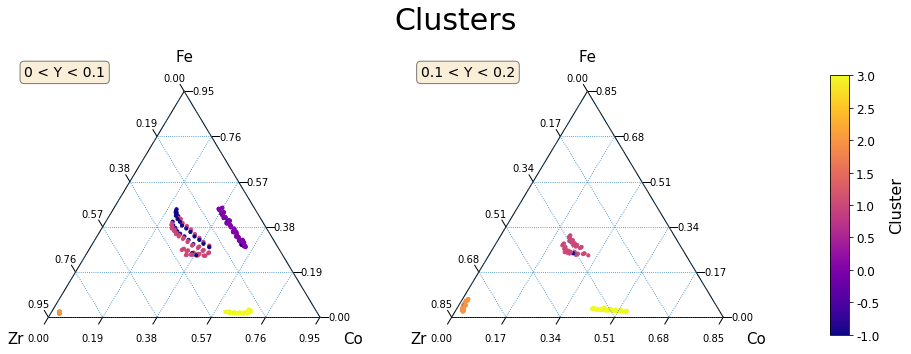

In [11]:
#ternary plots of all data with outliers outlined in red
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    try:
        quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=20,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},
                      scatter_kw=dict(marker='d',edgecolors='red',linewidths=0.8))
    except ValueError:
        pass
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('All data',size=30,y=1.1)


#ternary plots of inliers only - plot log_sigma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Inliers',size=30,y=1.1)

#ternary plots of outliers only - plot log_sigma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Outliers',size=30,y=1.1)

#ternary plots of all data with clusters identified
vmin = db_data['cluster'].min()
vmax = db_data['cluster'].max()
cmap = plt.cm.plasma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(db_data,z='cluster',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Cluster',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Clusters',size=30,y=1.1)

# Isolation forest + DBSCAN + Z-score

## Manual


In [31]:
ci_data = data.copy()

z_thresh = 2

#DBSCAN to cluster by composition
db = DBSCAN()
comp_dims = ['Ba','Co','Fe','Zr','Y']
#scale largest-variance atomic fraction to unit variance
#scale other atomic fractions with same transform
ref_dim = np.var(ci_data[comp_dims]).idxmax()
ss = StandardScaler()#with_centering=False)
ss.fit(ci_data[ref_dim].values[:,None])
scaled_comp = ss.transform(ci_data[comp_dims])
ci_data['cluster'] = db.fit_predict(scaled_comp)

#isolation forest on composition + log_sigma
iso_dims = comp_dims + ['log_sigma']
rand_state = np.random.RandomState(23)
clf = IsolationForest(random_state=rand_state)
clf.fit(ci_data[iso_dims])
ci_data['isolation_flag'] = clf.predict(ci_data[iso_dims])
ci_data['isolation_score'] = clf.decision_function(ci_data[iso_dims])

#get z-scores for each cluster and cross-ref with isolation forest
for i, cluster in enumerate(ci_data['cluster'].unique()):
    df = ci_data.loc[ci_data['cluster']==cluster,:]
    ci_data.loc[ci_data['cluster']==cluster,'cluster_zscore'] = z_score(df['log_sigma'])

#set final outlier flag - if flagged by isolation forest and cluster z-score is outside z_thresh
ci_data['outlier_flag'] = np.where((ci_data['isolation_flag']==-1) & (np.abs(ci_data['cluster_zscore']) > z_thresh), -1, 0)


0 4
1 26
2 20
3 3


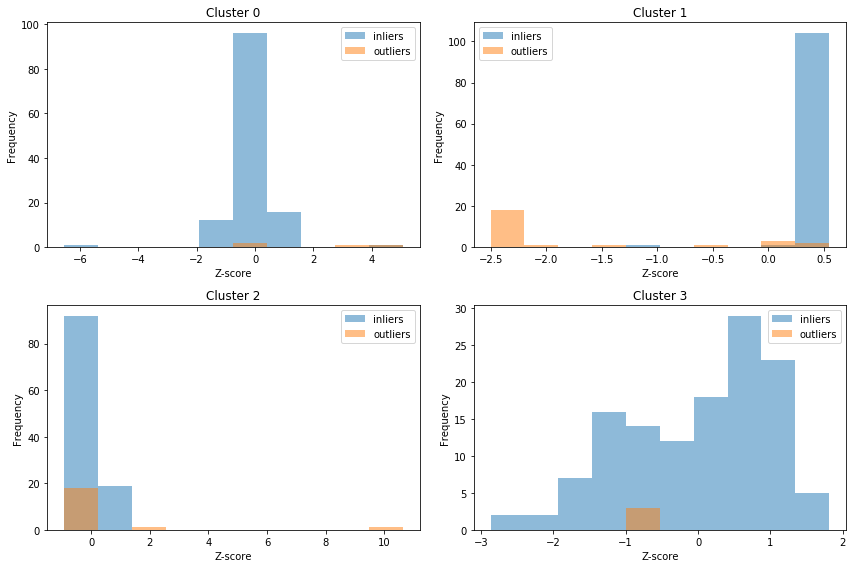

In [6]:
fig, axes = plt.subplots(2,2,figsize=(12,8))

for i, cluster in enumerate(ci_data['cluster'].unique()):
    df = ci_data.loc[ci_data['cluster']==cluster,:]
   
    num_outliers = len(df[df['isolation_flag']==-1])
    print(cluster, num_outliers)
    ax = axes[int(i/2), i%2]
    dfo = df[df['isolation_flag']==-1]
    dfi = df[df['isolation_flag']==1]
    hist, bins = np.histogram(df['cluster_zscore'])
    ax.hist(dfi['cluster_zscore'],alpha=0.5,bins=bins,label='inliers')
    ax.hist(dfo['cluster_zscore'],alpha=0.5,bins=bins, label='outliers')
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Z-score')
    ax.set_ylabel('Frequency')
    ax.legend()
fig.tight_layout()

Scale: 0.95
Scale: 0.95
Scale: 0.85
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


Text(0.5,1.1,'Outliers')

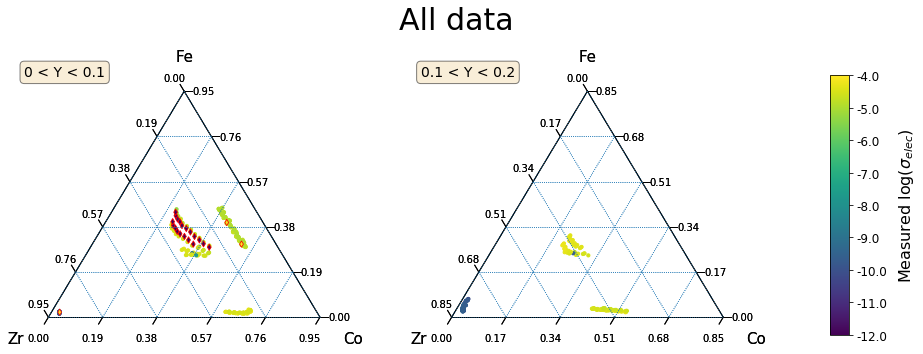

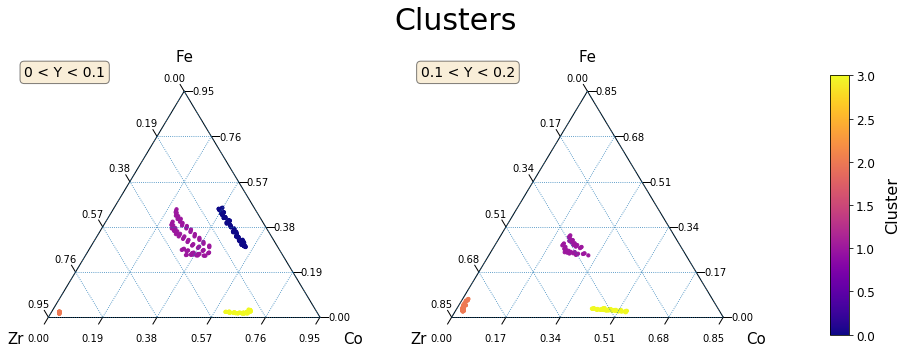

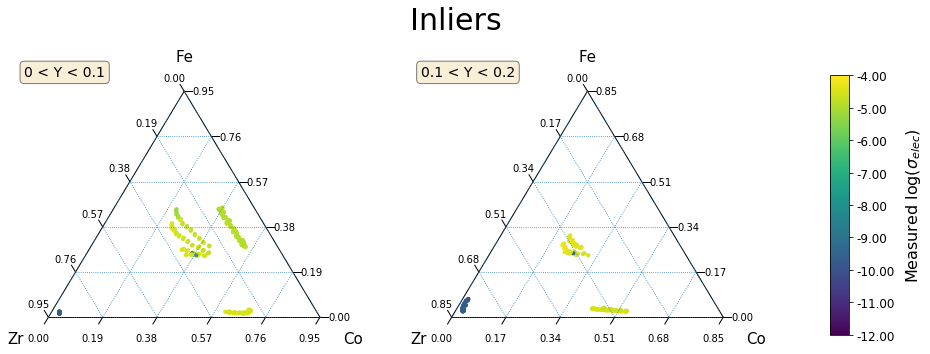

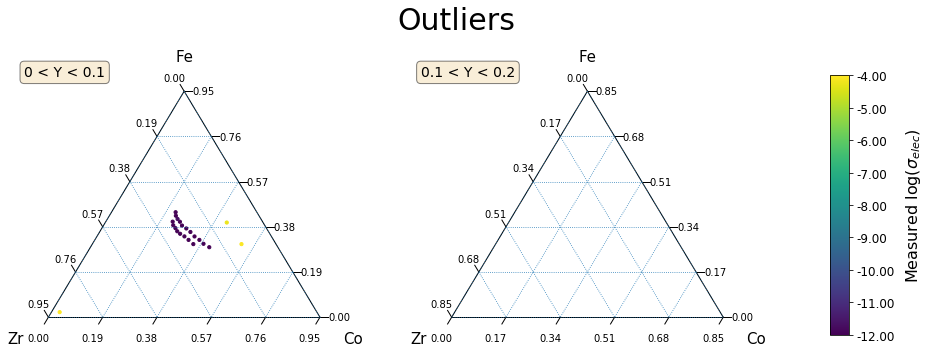

In [7]:
outliers = ci_data[ci_data['outlier_flag']==-1]
inliers = ci_data[ci_data['outlier_flag']==0]


#ternary plots of all data with outliers outlined in red
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    try:
        quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=20,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},
                      scatter_kw=dict(marker='d',edgecolors='red',linewidths=0.8))
    except ValueError:
        pass
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('All data',size=30,y=1.1)

#ternary plots of all data with clusters identified
vmin = ci_data['cluster'].min()
vmax = ci_data['cluster'].max()
cmap = plt.cm.plasma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(ci_data,z='cluster',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Cluster',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Clusters',size=30,y=1.1)

#ternary plots of inliers only - plot log_sigma
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Inliers',size=30,y=1.1)

#ternary plots of outliers only - plot log_sigma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    try:
        quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    except ValueError:
        ax.axis('off')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Outliers',size=30,y=1.1)



## Using equivalent function from outlier_detect

In [28]:
td = data.copy()
comp_dims = ['Ba','Co','Fe','Zr','Y']
td = td.join(flag_outliers(td,comp_dims,'log_sigma',full=True))

Scale: 0.95
Scale: 0.95
Scale: 0.85
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


Text(0.5,1.1,'Outliers')

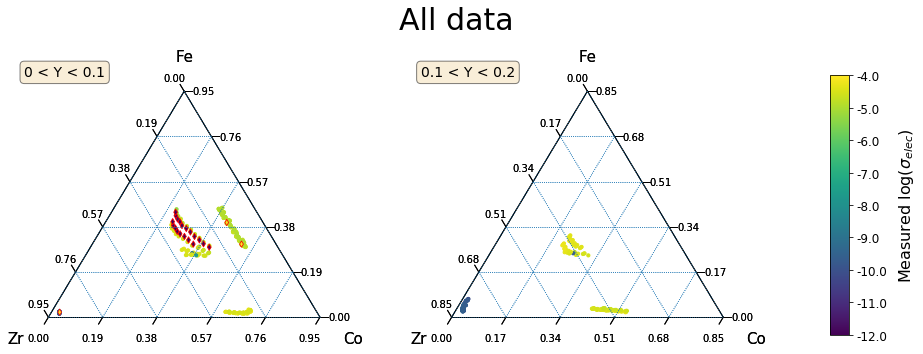

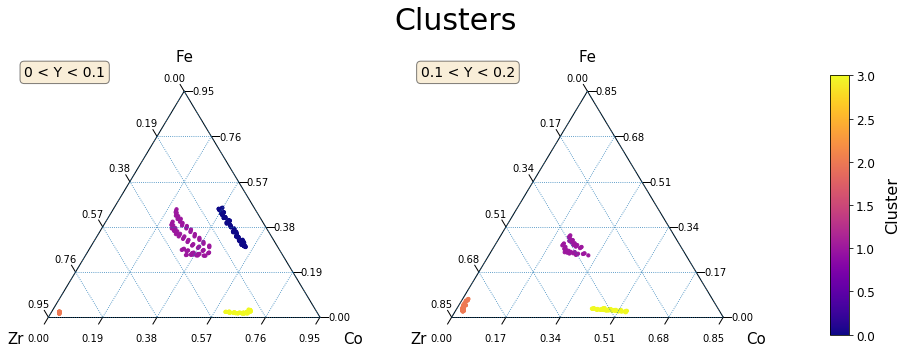

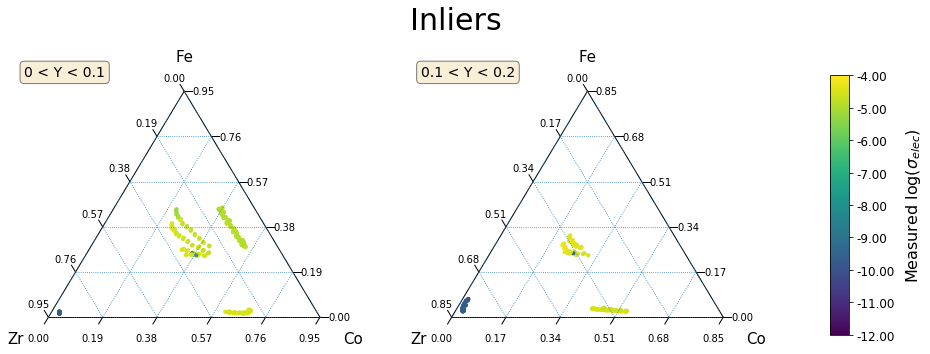

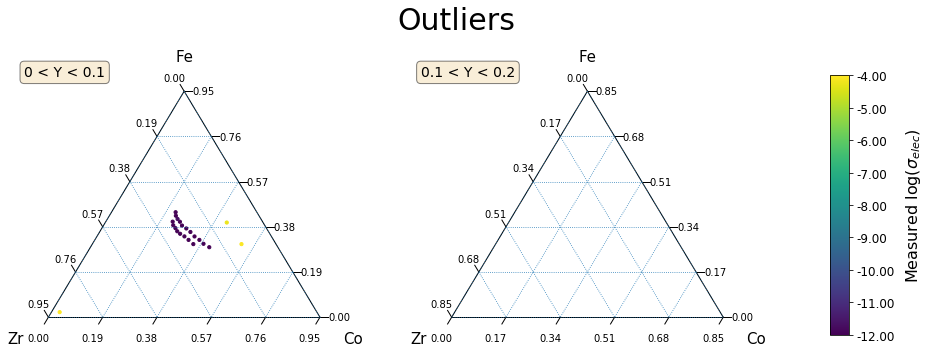

In [29]:
outliers = td[td['outlier_flag']==-1]
inliers = td[td['outlier_flag']==0]


#ternary plots of all data with outliers outlined in red
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    try:
        quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=20,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},
                      scatter_kw=dict(marker='d',edgecolors='red',linewidths=0.8))
    except ValueError:
        pass
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('All data',size=30,y=1.1)

#ternary plots of all data with clusters identified
vmin = td['cluster'].min()
vmax = td['cluster'].max()
cmap = plt.cm.plasma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(td,z='cluster',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Cluster',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Clusters',size=30,y=1.1)

#ternary plots of inliers only - plot log_sigma
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(inliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Inliers',size=30,y=1.1)

#ternary plots of outliers only - plot log_sigma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    try:
        quat_slice_scatter(outliers,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    except ValueError:
        ax.axis('off')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Outliers',size=30,y=1.1)